# Kernel Kernel Visualization

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from GPy import likelihoods
from GPy.core.parameterization.priors import Gaussian
from GPy.kern import RBFDistanceBuilderKernelKernel

from src.autoks.core.gp_model import GPModel
from src.autoks.core.grammar import BomsGrammar
from src.autoks.distance.distance import FrobeniusDistanceBuilder, ActiveModels

## Define helper functions

In [2]:
def covariances_to_gp_models(covariances):
    lik = likelihoods.Gaussian()
    gp_models = [GPModel(cov, lik) for cov in covariances]
    return gp_models

## Create kernels and data

In [3]:
# SE, RQ, PER, SE + PER
grammar = BomsGrammar(base_kernel_names=['SE', 'RQ', 'PER'])
grammar.build(1)
se, rq, per = grammar.base_kernels
se_plus_per = se + per

data_x = np.linspace(0., 1., 100)
data_x = data_x[:, None]
data_y = data_x ** 2

## Define parameters

In [4]:
max_n_models = 1000
num_samples = 20
max_num_hyperparameters = 40
noise_prior = Gaussian(np.log(0.01), np.sqrt(0.1))

## Create Active Model Set

In [5]:
selected_models = covariances_to_gp_models([se, rq, per, se_plus_per])

active_models = ActiveModels(max_n_models)
newly_inserted_indices = active_models.update(selected_models)
active_models.selected_indices = newly_inserted_indices


## Create Distance Builder

In [6]:
initial_candidate_indices = newly_inserted_indices
kernel_builder = FrobeniusDistanceBuilder(noise_prior, 
                                          num_samples, 
                                          max_num_hyperparameters, 
                                          max_n_models, 
                                          active_models, 
                                          initial_candidate_indices,
                                          data_x)

kernel_builder.compute_distance(active_models, initial_candidate_indices, initial_candidate_indices)

## Visualize Distance Matrix

Frobenius distance: 
 [[0.      0.18809 0.21726 0.2755 ]
 [0.18809 0.      0.07481 0.29743]
 [0.21726 0.07481 0.      0.30583]
 [0.2755  0.29743 0.30583 0.     ]]


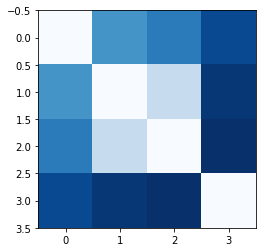

In [7]:
kernel_matrix = kernel_builder.get_kernel(len(active_models))
with np.printoptions(precision=5, suppress=True):
    print('Frobenius distance: \n', kernel_matrix)

plt.imshow(kernel_matrix, cmap='Blues')

## Visualize Kernel Kernel

Kernel kernel: 
 [[1.      0.98247 0.97667 0.96276]
 [0.98247 1.      0.99721 0.95673]
 [0.97667 0.99721 1.      0.95431]
 [0.96276 0.95673 0.95431 1.     ]]


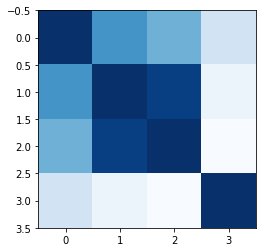

In [8]:
kernel_kernel = RBFDistanceBuilderKernelKernel(kernel_builder, n_models=len(active_models))

x_pred = np.array(initial_candidate_indices)
x_pred = x_pred[:, None]
kernel_kernel_matrix = kernel_kernel.K(x_pred)
plt.imshow(kernel_kernel_matrix, cmap='Blues')
with np.printoptions(precision=5, suppress=True):
    print("Kernel kernel: \n", kernel_kernel_matrix)